# Amazon Reviews Sentiment Analysis - Ferri Marco, Basso Matteo

This project aims to experiment with sentiment analysis on [Amazon Reviews](http://jmcauley.ucsd.edu/data/amazon/) in order to build a prediction model for rating, based on NLP.

## Import

In [1]:
import os
import gzip
import fileinput
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset reading

Util functions to read from JSON and convert into pandas dataframe:

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

Reading from JSON

In [3]:
basepath = r"datasets\amazon-5-core"
dataset = r"reviews_Video_Games_5.json.gz"
dfull = getDF(os.path.join(basepath, dataset))

basepath = r"datasets\amazon-original"
dataset = r"amazon_reviews_us_Books_v1_01.tsv"
file = os.path.join(basepath, dataset);

open = fileinput.input([file], inplace=True, backup='.bak');
for line in open:
    sys.stdout.write(re.sub(r'(?<!,)"(?!,)', r'""', line))

dfull = pd.read_csv(file, sep = '\t', index_col=False, nrows = 70, engine = 'python')

Columns renaming

In [4]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

##  Dataset description

### Shape and schema

In [5]:
dfull.shape

(231780, 9)

In [6]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231780 entries, 0 to 231779
Data columns (total 9 columns):
userID            231780 non-null object
productID         231780 non-null object
userName          228967 non-null object
helpful           231780 non-null object
text              231780 non-null object
rating            231780 non-null float64
summary           231780 non-null object
unixReviewTime    231780 non-null int64
reviewTime        231780 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 10.6+ MB


Little dataset preview:

In [7]:
dfull.head(3)

,userID,productID,userName,helpful,text,rating,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4.0,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1.0,Wrong key,1403913600,"06 28, 2014"


### Columns analysis

#### Users and products

In [8]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Avarage REVIEWS PER USER: ", rows/n_users)
print("Avarage REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  231780
Number of USERS:  24303
Number of PRODUCTS:  10672
Avarage REVIEWS PER USER:  9.537094185902975
Avarage REVIEWS PER PRODUCT:  21.718515742128936


#### Datetime

In [9]:
dfull['date'] = pd.to_datetime(dfull['unixReviewTime'],unit='s')
print("First date: ", min(dfull['date']))
print("Last date: ", max(dfull['date']))

First date:  1999-10-14 00:00:00
Last date:  2014-07-22 00:00:00


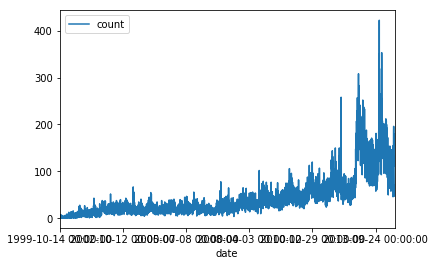

In [11]:
date_grouping = dfull.groupby('date').count()[['rating']].sort_values('date', ascending=True)
date_grouping = date_grouping.rename(index=str, columns={"rating": "count"})
date_grouping.plot()

#### Rating

In [12]:
dfull['rating'].mean()

4.086396582966606

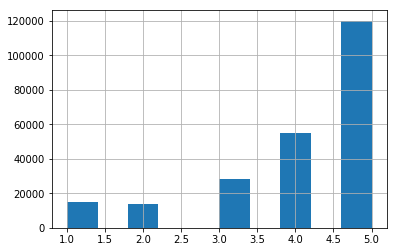

In [13]:
dfull['rating'].hist()